In [39]:
import anndata
import igraph
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import rpy2.robjects as robj
import scanpy as sc
import scipy
import scipy.optimize
import scvelo as scv
import sklearn
import velocyto as vcy

from collections import Counter
from IPython.core.display import display, HTML
from numpy_groupies import aggregate, aggregate_np
#from rpy2.robjects.packages import importr
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

matplotlib.rcParams.update({'font.size': 12})

In [40]:
adata_06 = anndata.read('SRR6470906/counts_unfiltered/adata.h5ad')
adata_07 = anndata.read('SRR6470907/counts_unfiltered/adata.h5ad')

In [41]:
# Before we do, we need to make sure we can trace each row back to its
# original anndata object.
adata_06.obs['run'] = '06'
adata_07.obs['run'] = '07'
adata_06.obs['bcs'] = adata_06.obs.index
adata_07.obs['bcs'] = adata_07.obs.index
adata_06.obs.index = adata_06.obs['bcs'] + '.' + adata_06.obs['run']
adata_07.obs.index = adata_07.obs['bcs'] + '.' + adata_07.obs['run']

adata = adata_06.concatenate(adata_07, batch_key='batch')

In [42]:
#Showing Spliced/Unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.65 0.28]


AnnData object with n_obs × n_vars = 374814 × 58367
    obs: 'run', 'bcs', 'batch'
    layers: 'spliced', 'unspliced'

In [43]:
adata.obs.head()

,run,bcs,batch
AAACCTGAGAAACCGC.06-0,06,AAACCTGAGAAACCGC,0
AAACCTGAGAAGGACA.06-0,06,AAACCTGAGAAGGACA,0
AAACCTGAGAAGGCCT.06-0,06,AAACCTGAGAAGGCCT,0
AAACCTGAGAAGGGTA.06-0,06,AAACCTGAGAAGGGTA,0
AAACCTGAGAAGGTTT.06-0,06,AAACCTGAGAAGGTTT,0


In [44]:
adata.obs.index = adata.obs.index.str.split('-').str[0]
adata.obs.head()

,run,bcs,batch
AAACCTGAGAAACCGC.06,06,AAACCTGAGAAACCGC,0
AAACCTGAGAAGGACA.06,06,AAACCTGAGAAGGACA,0
AAACCTGAGAAGGCCT.06,06,AAACCTGAGAAGGCCT,0
AAACCTGAGAAGGGTA.06,06,AAACCTGAGAAGGGTA,0
AAACCTGAGAAGGTTT.06,06,AAACCTGAGAAGGTTT,0


In [45]:
adata.var.head()

""
gene_id
ENSG00000277400.1
ENSG00000274847.1
ENSG00000276256.1
ENSG00000278198.1
ENSG00000273496.1


In [46]:
adata.var.index = adata.var.index.str.split('.').str[0]
adata.var.head()

""
gene_id
ENSG00000277400
ENSG00000274847
ENSG00000276256
ENSG00000278198
ENSG00000273496


In [47]:
adata

AnnData object with n_obs × n_vars = 374814 × 58367
    obs: 'run', 'bcs', 'batch'
    layers: 'spliced', 'unspliced'

In [48]:
#Download to matrix to make final
them = scv.read('data/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [49]:
#Download to matrix to make final part 2
them.obs["bcs"] = them.obs.index.str.slice(11,-1)
them.obs["bid"] = them.obs.index.str.slice(8,10)
them.obs["run"] = them.obs.bid.map(lambda x: "06" if x=="29" else "07")
them.obs.index = them.obs.bcs.values + "."+ them.obs["run"]

In [50]:
#Download to matrix to make final part 3
final = adata[adata.obs.index.isin(them.obs.index),:]
final = final[:,final.var.index.isin(them.var.Accession)]

In [51]:
final

View of AnnData object with n_obs × n_vars = 1720 × 31029
    obs: 'run', 'bcs', 'batch'
    layers: 'spliced', 'unspliced'

In [52]:
final.write_loom('final.loom')

In [53]:
adata

AnnData object with n_obs × n_vars = 374814 × 58367
    obs: 'run', 'bcs', 'batch'
    layers: 'spliced', 'unspliced'

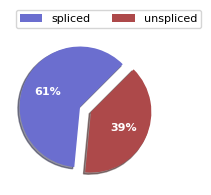

In [55]:
scv.pl.proportions(final)

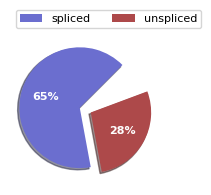

In [56]:
scv.pl.proportions(adata)

In [59]:
adata = final
adata

View of AnnData object with n_obs × n_vars = 1720 × 31029
    obs: 'run', 'bcs', 'batch'
    layers: 'spliced', 'unspliced'

In [62]:
adata = scv.read('final.loom', cache=True)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1720 × 31029
    obs: 'batch', 'bcs', 'run'
    layers: 'matrix', 'spliced', 'unspliced'

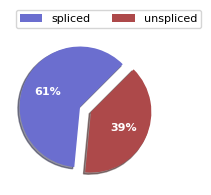

In [63]:
scv.pl.proportions(adata)

In [64]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 23536 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.


In [65]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 60 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [66]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [67]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

KeyError: 'X_umap'

In [68]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

computing velocity embedding


ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

In [69]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


KeyError: 'clusters'

In [70]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

NameError: name 'df' is not defined